In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd

import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.cm as cm
import pickle as pkl
import matplotlib.pyplot as plt
# Single methods
from sklearn.preprocessing import MinMaxScaler as Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from Modules.Clustering_Utils_Zamuro import plot_silhouette
from Modules.Clustering_Utils_Zamuro import plot_centroids
from Modules.Clustering_Utils_Zamuro import ClusteringResults
from sklearn.metrics import davies_bouldin_score as DB
from sklearn.metrics import calinski_harabasz_score as CH
import folium
from folium.plugins import HeatMap

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

In [50]:
root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
root_ai_Zamuro = f"{root}/Zamuro/AI_Caract/AI_Zamuro.csv"
audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders_satelites.csv", index_col=0)
# df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
df_ai = pd.read_csv(root_ai_Zamuro, index_col=0)
df_ai.dropna(inplace=True)
df_ai.rename(columns={"file":"y"}, inplace=True)

In [61]:
df_ae.set_index("y", drop=False, inplace=True)
df_ai.set_index("y", drop=False, inplace=True)
audios.set_index("y", drop=False, inplace=True)

df_ai = df_ai[df_ai.index.isin(df_ae.index)]
audios = audios[audios.index.isin(df_ae.index)]

# df_ai.reset_index(drop=True, inplace=True)
# audios.reset_index(drop=True, inplace=True)
AIs = np.asarray(df_ai.iloc[:,2::])


In [62]:
df_ai

,Date,y,ZCR,MEANt,VARt,SKEWt,KURTt,LEQt,BGNt,SNRt,...,H_Havrda,H_Renyi,H_pairedShannon,H_gamma,H_GiniSimpson,RAOQ,AGI,ROItotal,ROIcover,cluster
y,,,,,,,,,,,,,,,,,,,,,
RZUA01_20220903_180000.WAV,2022-09-03 18:00:00,RZUA01_20220903_180000.WAV,26602.833333,6.055727e-19,0.000455,0.048461,103.370373,59.598129,-26.396262,4.286802,...,0.332768,3.189879,5.609961,21995.310950,0.975591,0.381408,1.367189,1714,5.867066,0
RZUA01_20220903_181500.WAV,2022-09-03 18:15:00,RZUA01_20220903_181500.WAV,16407.600000,-5.003039e-19,0.000985,0.080386,17.124613,62.954323,-22.284621,1.648931,...,0.324696,1.826497,4.122089,8014.670960,0.878845,0.151191,1.304565,1809,4.308646,0
RZUA01_20220903_183000.WAV,2022-09-03 18:30:00,RZUA01_20220903_183000.WAV,24489.800000,6.020551e-19,0.000388,0.173712,89.232058,58.911660,-26.096947,2.965044,...,0.332703,3.135466,5.358734,16129.520786,0.970744,0.266430,1.293021,1606,4.019033,0
RZUA01_20220903_184500.WAV,2022-09-03 18:45:00,RZUA01_20220903_184500.WAV,21609.116667,3.144957e-19,0.000389,0.084346,44.104228,58.923570,-26.598463,2.319384,...,0.329745,2.265738,4.654825,11561.204542,0.930396,0.192815,1.277244,1679,4.230561,0
RZUA01_20220903_190000.WAV,2022-09-03 19:00:00,RZUA01_20220903_190000.WAV,20622.383333,-5.898156e-19,0.000406,0.140226,15.979357,59.109808,-26.839792,1.901341,...,0.323256,1.749408,4.101539,9160.394282,0.875518,0.153642,1.262718,1480,3.981870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RZUH13_20220912_070000.WAV,2022-09-12 07:00:00,RZUH13_20220912_070000.WAV,37127.500000,2.395268e-19,0.000028,-0.123534,4.308900,47.563859,-36.848782,0.656902,...,0.331340,2.559663,5.339655,29643.924914,0.949995,0.384166,1.213904,1877,0.920458,2
RZUH13_20220912_071500.WAV,2022-09-12 07:15:00,RZUH13_20220912_071500.WAV,42607.800000,-5.329456e-21,0.000021,-0.147668,3.495183,46.161754,-37.072927,0.413386,...,0.333054,3.542602,6.072762,39963.027352,0.982991,0.473620,1.213884,1829,1.042269,2
RZUH13_20220912_073000.WAV,2022-09-12 07:30:00,RZUH13_20220912_073000.WAV,43009.266667,7.441964e-20,0.000019,-0.064865,4.044839,45.871403,-37.762048,0.553588,...,0.333084,3.599382,6.137805,41127.560031,0.984871,0.478226,1.217297,2570,1.936579,2


In [63]:
audios

,index,field_number_PR,longitud_IG,latitude_IG,day_init_TI,day_end_TI,samp_rate_RE,habitat,pasture,savanna,forest,cover,Filename,name_FI,rain_FI,y,location,day,hour,hour_stage
y,,,,,,,,,,,,,,,,,,,,
RZUA01_20220906_063000.WAV,0,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.00000,pasture,20220906_063000.WAV,20220906_063000,NO,RZUA01_20220906_063000.WAV,RZUA01,6,6,morning
RZUA01_20220903_180000.WAV,30,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.00000,pasture,20220903_180000.WAV,20220903_180000,NO,RZUA01_20220903_180000.WAV,RZUA01,3,18,night
RZUA01_20220903_181500.WAV,31,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.00000,pasture,20220903_181500.WAV,20220903_181500,NO,RZUA01_20220903_181500.WAV,RZUA01,3,18,night
RZUA01_20220903_183000.WAV,32,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.00000,pasture,20220903_183000.WAV,20220903_183000,NO,RZUA01_20220903_183000.WAV,RZUA01,3,18,night
RZUA01_20220903_184500.WAV,33,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.00000,pasture,20220903_184500.WAV,20220903_184500,NO,RZUA01_20220903_184500.WAV,RZUA01,3,18,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RZUD01M_20220911_074500.WAV,767,RZUD01M,-73.400768,3.555762,3,11,192000,bosque,0.786941,0.000008,0.21305,pasture,20220911_074500.WAV,20220911_074500,NO,RZUD01M_20220911_074500.WAV,RZUD01M,11,7,morning
RZUD01M_20220911_080000.WAV,768,RZUD01M,-73.400768,3.555762,3,11,192000,bosque,0.786941,0.000008,0.21305,pasture,20220911_080000.WAV,20220911_080000,NO,RZUD01M_20220911_080000.WAV,RZUD01M,11,8,morning
RZUD01M_20220911_081500.WAV,769,RZUD01M,-73.400768,3.555762,3,11,192000,bosque,0.786941,0.000008,0.21305,pasture,20220911_081500.WAV,20220911_081500,NO,RZUD01M_20220911_081500.WAV,RZUD01M,11,8,morning


In [68]:
Clustering = KMeans(n_clusters=5, random_state=0).fit(AIs)
df_ai['cluster'] = Clustering.labels_
df_ai.set_index("y", inplace=True, drop=False)
df_ai.rename_axis('Filename_', inplace=True)

audios_filtered = audios[audios.index.isin(df_ai.index)]
audios_final = audios_filtered.join(df_ai['cluster'], how='left')

conteo_clusters = audios_final.groupby(['location', 'cluster']).size().unstack(fill_value=0)
conteo_clusters.columns = [f'cluster_{col}' for col in conteo_clusters.columns]
recorders_clusters = recorders.join(conteo_clusters, on='field_number_PR')

In [69]:
recorders_clusters

,field_number_PR,longitud_IG,latitude_IG,day_init_TI,day_end_TI,samp_rate_RE,habitat,pasture,savanna,forest,...,ICHN200_b200mean_200,ICHN200_b200median_200,ICHN100_b100mean_100,ICHN100_b100median_100,ICHN2022,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,RZUA01,-73.411659,3.555860,3,14,192000,bosque,1.000000,0.000000,0.000000,...,0.876312,0.957621,0.983765,0.989564,6.409862,425,0,162,243,45
1,RZUA02,-73.411659,3.552269,3,14,192000,bosque,1.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,102,0,72,361,2
2,RZUA03b,-73.411520,3.548784,8,14,192000,pastizal,0.705108,0.294892,0.000000,...,0.779726,0.922898,0.722209,0.779019,4.829493,4,0,4,0,0
3,RZUA04,-73.411514,3.544981,3,14,192000,borde,0.589278,0.410722,0.000000,...,0.719122,0.789548,0.531630,0.499752,4.269625,1,0,5,1,5
4,RZUA05,-73.411571,3.541357,5,13,192000,borde,0.892664,0.000000,0.107336,...,0.789717,0.881927,0.708318,0.742850,4.524839,8,0,12,41,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,RZUH10,-73.386542,3.523509,4,12,192000,borde,0.100542,0.311728,0.587730,...,0.310535,0.202993,0.210764,0.164337,2.862457,106,0,167,222,136
90,RZUH11,-73.386250,3.519590,4,12,192000,sabana,0.000000,0.734056,0.265944,...,0.200375,0.170276,0.247308,0.283583,3.121909,301,0,76,268,0
91,RZUH12,-73.386458,3.516031,4,12,192000,sabana,0.149383,0.850617,0.000000,...,0.324104,0.322671,0.369220,0.338752,3.852229,203,0,12,416,0
92,RZUH13,-73.386398,3.512511,4,12,192000,borde,0.492125,0.286392,0.221483,...,0.496969,0.383130,0.480467,0.388688,4.083756,141,0,128,146,247


In [70]:
# Supongamos que quieres verificar los datos para una grabadora específica, por ejemplo, "grabadora_1"
grabadora = "RZUH12"  # Cambia esto al nombre de la grabadora que quieres verificar

# Filtrar los datos de audios_final para esta grabadora específica
audios_grabadora = audios_final[audios_final['location'] == grabadora]

# Contar la cantidad de audios en cada cluster para esta grabadora
conteo_por_cluster = audios_grabadora['cluster'].value_counts()

# Mostrar el resultado
print(conteo_por_cluster)

conteo_clusters = audios_final['cluster'].value_counts()

# Mostrar el resultado
print(conteo_clusters)

cluster
3    416
0    203
2     12
Name: count, dtype: int64
cluster
3    23135
0    15519
2    10078
4     4542
1        1
Name: count, dtype: int64


In [72]:
%matplotlib qt
mapa = folium.Map(location=[3.515, -73.411489], zoom_start=14.2)

puntos = recorders_clusters[['latitude_IG', 'longitud_IG', 'cluster_1']].values.tolist()
# valores = recorders_clusters["cluster_4"].tolist()
HeatMap(puntos, radius=20, ).add_to(mapa)
mapa

In [73]:
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from scipy.interpolate import griddata


In [74]:
# Filtrar el DataFrame eliminando las filas donde field_number_PR sea igual a 'RZUD06'
recorders_clusters = recorders_clusters[recorders_clusters['field_number_PR'] != 'RZUD06']
audios = audios[audios['field_number_PR'] != 'RZUD06']

# Opcional: resetear el índice si es necesario
recorders_clusters.reset_index(drop=True, inplace=True)
audios.reset_index(drop=True, inplace=True)



In [75]:
geometry = [Point(xy) for xy in zip(recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG'])]
gdf = gpd.GeoDataFrame(recorders_clusters, geometry=geometry)

# Cargar el archivo TIF para obtener los límites del mapa
tif_path = 'Complementary_Files/AD.tif'

with rasterio.open(tif_path) as tif:
    bounds = tif.bounds

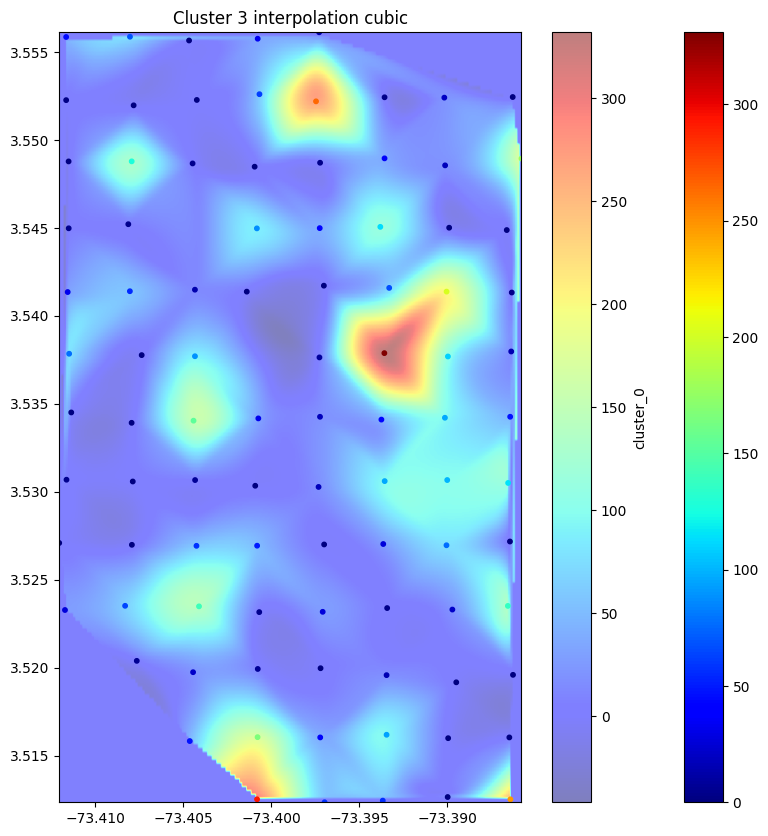

In [83]:
%matplotlib inline
resolution = 200

# Crea una cuadrícula regular para la interpolación
x_min, x_max = recorders_clusters['longitud_IG'].min(), recorders_clusters['longitud_IG'].max()
y_min, y_max = recorders_clusters['latitude_IG'].min(), recorders_clusters['latitude_IG'].max()
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Realiza la interpolación utilizando griddata
Z3 = griddata((recorders_clusters['longitud_IG'], recorders_clusters['latitude_IG']), recorders_clusters['cluster_4'], (X, Y), method='cubic',fill_value=0)

fig, ax = plt.subplots(figsize=(10, 10))

# Visualiza los puntos originales
gdf.plot(ax=ax, column='cluster_4', cmap='jet', markersize=10, legend=True)

# Visualiza la interpolación como un mapa de calor
im = ax.imshow(Z3, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5)
plt.colorbar(im, ax=ax, label='cluster_0')
limited_dataimg = im.get_array()

ax.set_title('Cluster 3 interpolation cubic')
plt.show()


In [ ]:
indices_acusticos = df_ai.columns[2:-1]  # Desde la columna 2 hasta la penúltima
clusters = df_ai['cluster']  # Supongamos que la última columna se llama 'cluster'

# Crear un DataFrame para la visualización
df_plot = df_ai.melt(id_vars='cluster', value_vars=indices_acusticos, 
                     var_name='Índice Acústico', value_name='Valor')

# Crear el scatter plot con seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_plot, x='Índice Acústico', y='Valor', hue='cluster', palette='tab10')

# Configurar título y etiquetas
plt.title('Distribución de Índices Acústicos por Cluster', fontsize=14)
plt.xlabel('Índice Acústico', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

/tmp/ipykernel_6821/1497277992.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canv

In [ ]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_plot, x='Índice Acústico', y='Valor', hue='cluster', palette='tab10')

# Configurar título y etiquetas
plt.title('Distribución de Índices Acústicos por Cluster (Boxplot)', fontsize=14)
plt.xlabel('Índice Acústico', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

/tmp/ipykernel_6821/2050009713.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canv

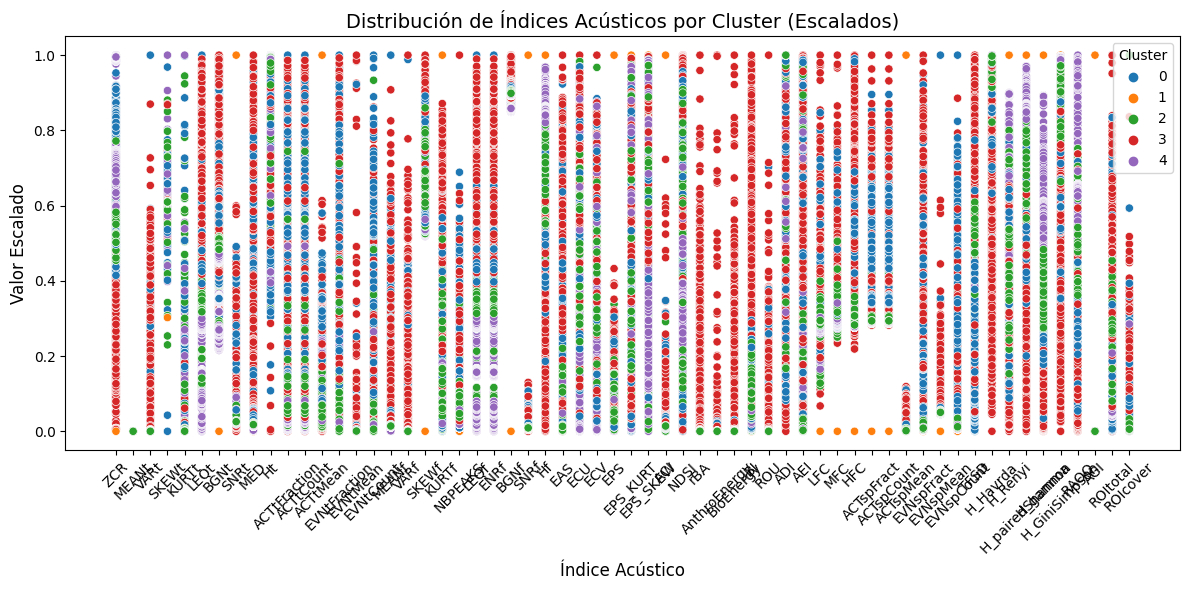

In [87]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas con los índices acústicos
indices_acusticos = df_ai.columns[2:-1]

# Crear un escalador MinMax
scaler = MinMaxScaler()

# Escalar los valores de los índices acústicos
df_ai[indices_acusticos] = scaler.fit_transform(df_ai[indices_acusticos])

# Convertir el DataFrame a formato largo para la visualización
df_plot = df_ai.melt(id_vars='cluster', value_vars=indices_acusticos, 
                     var_name='Índice Acústico', value_name='Valor')

# Crear el scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_plot, x='Índice Acústico', y='Valor', hue='cluster', palette='tab10')

# Configurar título y etiquetas
plt.title('Distribución de Índices Acústicos por Cluster (Escalados)', fontsize=14)
plt.xlabel('Índice Acústico', fontsize=12)
plt.ylabel('Valor Escalado', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

/tmp/ipykernel_6821/3096390562.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


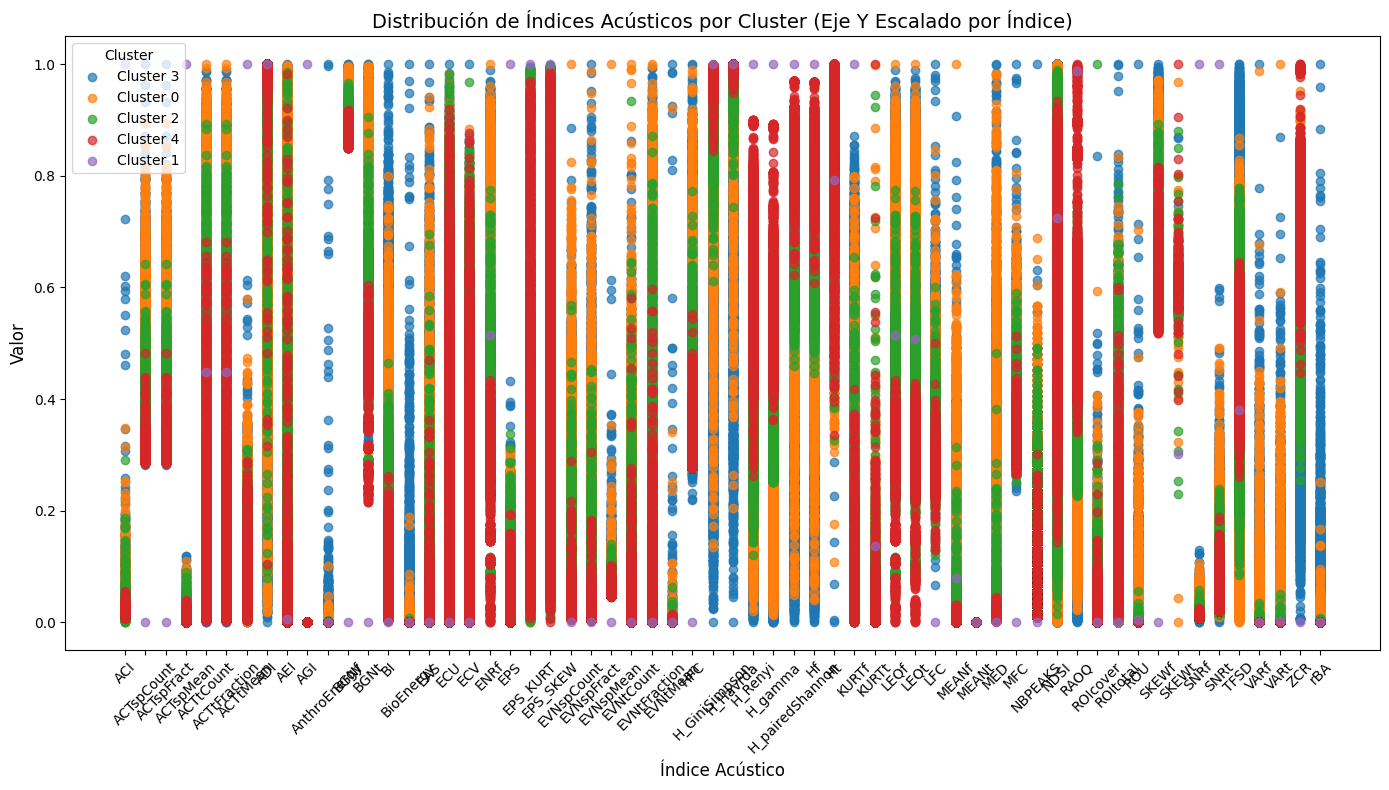

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir el DataFrame a formato largo
indices_acusticos = df_ai.columns[2:-1]
df_plot = df_ai.melt(id_vars='cluster', value_vars=indices_acusticos, 
                     var_name='Índice Acústico', value_name='Valor')

# Asignar valores únicos de X para cada índice
df_plot['X'] = df_plot['Índice Acústico'].astype('category').cat.codes

# Crear el scatter plot con diferentes colores por cluster
plt.figure(figsize=(14, 8))

for cluster in df_plot['cluster'].unique():
    subset = df_plot[df_plot['cluster'] == cluster]
    plt.scatter(subset['X'], subset['Valor'], label=f'Cluster {cluster}', alpha=0.7)

# Configurar el eje X con etiquetas de los índices
plt.xticks(ticks=df_plot['X'].unique(), labels=indices_acusticos, rotation=45)

# Configurar título y etiquetas
plt.title('Distribución de Índices Acústicos por Cluster (Eje Y Escalado por Índice)', fontsize=14)
plt.xlabel('Índice Acústico', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Cluster')
plt.tight_layout()

# Mostrar la gráfica
plt.show()